In [9]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as T
import matplotlib.pyplot as plt

In [10]:
# Gettint the dataset
root = "data/"

transform = T.Compose([
    T.Resize((128,128)),
    T.ToTensor()
])

train_ds = datasets.Flowers102(root,split="train",transform=transform,download=True)
train_dl = torch.utils.data.DataLoader(train_ds,batch_size=32)

100%|██████████| 345M/345M [01:04<00:00, 5.37MB/s] 


Extracting data/flowers-102/102flowers.tgz to data/flowers-102


100%|██████████| 502/502 [00:00<00:00, 574kB/s]


100%|██████████| 15.0k/15.0k [00:00<00:00, 21.5MB/s]


In [3]:
def plot_image(x):
    x = x.permute(1, 2, 0)
    plt.imshow(x.numpy())

def get_betas(T):
    beta_start = 1e-4
    beta_end = 0.1
    betas = torch.linspace(beta_start, beta_end, T)
    return betas

def calculate_alpha(betas):
    alphas = 1 - betas
    alphas_tilda = torch.cumprod(alphas, dim=0)
    return alphas, alphas_tilda

def dummy_forward(x0, T, alpha_tilda, device="cuda"):
    sqrt_alpha_tilda_t = torch.sqrt(alpha_tilda[T-1]).to(device)
    sqrt_one_minus_alpha_tilda_t = torch.sqrt(1 - alpha_tilda[T-1]).to(device)

    epsilon = torch.randn_like(x0).to(device)

    xt = sqrt_alpha_tilda_t * x0 + sqrt_one_minus_alpha_tilda_t * epsilon
    return xt.to(device)

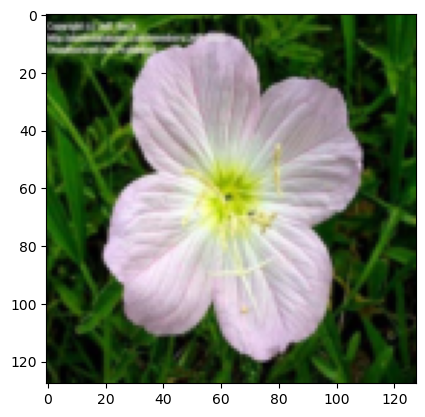

In [4]:
x,y = train_ds[1]
plot_image(x)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.02660795..1.0118492].


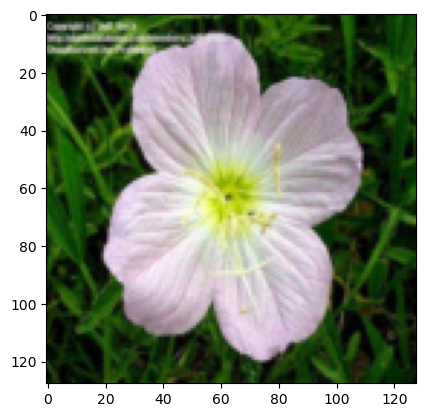

In [5]:
T = 1
device = "cpu"
x.to(device)
betas = get_betas(T)
_,alpha_tilda = calculate_alpha(betas)

xT = dummy_forward(x,T,alpha_tilda,device)
plot_image(xT)

In [6]:
class DownScale(nn.Module):
    def __init__(self, input_channels, output_channels):
        super().__init__()
        self.conv = nn.Conv2d(input_channels, output_channels, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm2d(output_channels)
        self.pooling = nn.MaxPool2d(2)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.relu(x)
        x = self.pooling(x)
        x = self.bn(x)
        return x

class UppScale(nn.Module):
    def __init__(self, input_channels, output_skip_channels, output_channels):
        super().__init__()
        self.conv = nn.ConvTranspose2d(input_channels + output_skip_channels, output_channels, kernel_size=4, stride=2, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.bn = nn.BatchNorm2d(output_channels)

    def forward(self, x_input, x_skip):
        x = torch.cat((x_input, x_skip), dim=1)
        x = self.conv(x)
        x = self.relu(x)
        x = self.bn(x)
        return x

class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder= nn.ModuleList([
            DownScale(3,64),
            DownScale(64,128),
            DownScale(128,256),
            DownScale(256,512)
        ])

        self.decoder = nn.ModuleList([
            UppScale(512,512,512),
            UppScale(256,512,256),
            UppScale(128,256,128),
            UppScale(128,64,3),
        ])

    def forward(self, x):
        skip_connections = []
        for down in self.encoder:
            x = down(x)
            skip_connections.append(x)

        skip_connections = skip_connections[::-1]

        for idx, up in enumerate(self.decoder):
            x = up(x, skip_connections[idx])

        return x


In [25]:
model = UNet()
aux = torch.randn(1, 3, 128, 128)
model(aux).shape

torch.Size([1, 3, 128, 128])

In [26]:
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.65669006..6.206351].


Epoch 1/10, Loss: 1.946989070624113


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.654381..7.0287766].


Epoch 2/10, Loss: 1.9412686824798584


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6631684..5.9989133].


Epoch 3/10, Loss: 1.9350452683866024


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.65529996..5.9941554].


Epoch 4/10, Loss: 1.9288159906864166


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6515895..6.7888107].


Epoch 5/10, Loss: 1.9231650903820992


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6493091..6.2514195].


Epoch 6/10, Loss: 1.9166771620512009


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6508261..6.3977113].


Epoch 7/10, Loss: 1.9110724665224552


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6486071..5.785068].


Epoch 8/10, Loss: 1.905292097479105


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.64743394..6.3797755].


Epoch 9/10, Loss: 1.8987544625997543


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.63987035..6.1909246].


Epoch 10/10, Loss: 1.8926732763648033


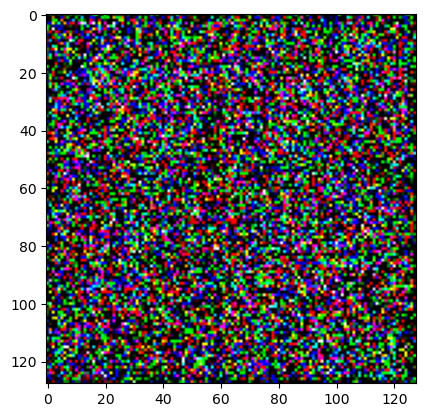

In [31]:
%matplotlib inline

loss_fn = nn.MSELoss()
epochs = 10
T = 1000
device = "cuda"
betas = get_betas(T).to(device)
alphas , alpha_tilda = calculate_alpha(betas)
model = model.to(device)
for epoch in range(epochs):
    model.train()
    total_loss = 0
    losses = []
    for i,(img,_) in enumerate(train_dl):
        img = img.to(device)
        noise = torch.randn_like(img).to(device)
        img = dummy_forward(img,T,alpha_tilda,device)

        optimizer.zero_grad()
        output = model(img)
        loss = loss_fn(output,noise)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(train_dl)}")

    random = torch.randn(1,3,128,128).to(device)
    image = model(random).squeeze(0).cpu().detach()
    plot_image(image)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6400233..7.035283].


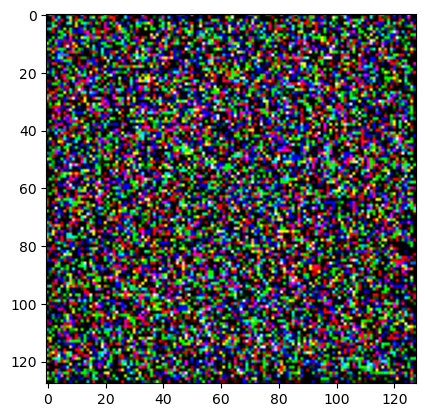

In [ ]:
random = torch.randn(1,3,128,128).to(device)
image = model(random).squeeze(0).cpu().detach()
plot_image(image)
